In [1]:
import numpy as np
import sys
sys.path.append("../../../")
from SWIDP.process_1d_deep import *
from SWIDP.dispersion import generate_mixed_samples,calculate_dispersion,transform_vs_to_vel_model
from p_tqdm import p_map

In [2]:
# step1: get 1d velocity model (vp model or vs)
depth_vs = np.loadtxt("./vs_demo.txt")
depth = depth_vs[:,0]
vs = depth_vs[:,1]

# step2-1: remove the thin sandwidth layer
vs = combine_thin_sandwich(vs,
                            depth,
                            thickness_threshold=12, # km
                            uniform_thickness=1,    # km (thickness_threshold/uniform_thickness) = max_check_layers
                            gradient_threshold=0.05, # km/s (gradient_threshold)
                            return_idx=False
                            )

# step2-2: smooth the vs model (selectable)
vs = smooth_vs_by_node_interp(vs,
                            depth,
                            n_nodes=20,
                            method="pchip"
                            )

# step3: find moho index
moho_idx = find_moho_depth(vs,
                           depth,
                           [5,90], # range of moho index
                           gradient_search=False,
                           gradient_threshold=0.01)

# step4: augment the vs model
perturb_nums = 100
vs_augmented = p_map(augment_crust_moho_mantle,
                    [vs]*perturb_nums,
                    list(depth.reshape(1,-1))*perturb_nums,
                    [moho_idx]*perturb_nums,
                    [[-0.1,0.1]]*perturb_nums, # relative ratio
                    [[3,8]]*perturb_nums,     # nodes for crust
                    [[8,15]]*perturb_nums,   # nodes for mantle
                    [3]*perturb_nums,          # km 
                    [2]*perturb_nums,     # km
                    [False]*perturb_nums,
                    np.random.randint(0,1000000,perturb_nums)
                    )

# step5: transform the vs model to vp model
vel_models = p_map(transform_vs_to_vel_model,list(vs_augmented),[depth]*len(vs_augmented))

# step6: calculate the dispersion curve
t = generate_mixed_samples(num_samples=300,start=1,end=100,uniform_num=100,log_num=100,random_num=100)
t = np.ones((len(vel_models),len(t)))*t
disp_data = p_map(calculate_dispersion, vel_models, list(t))
disp_data = np.array(disp_data)
vel_models = np.array(vel_models)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

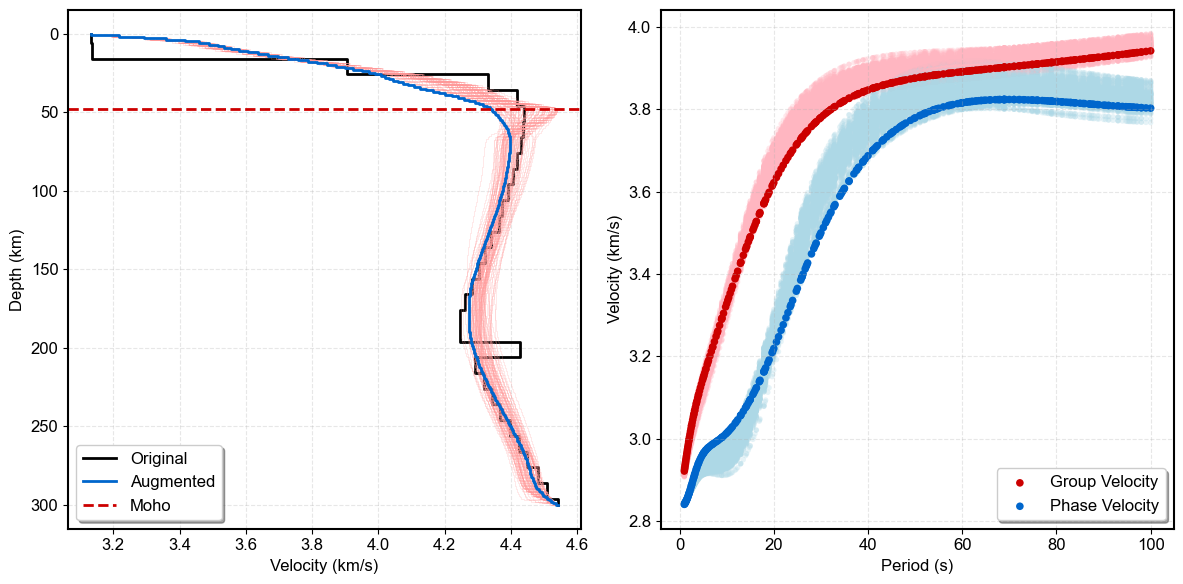

In [5]:
# figure
import matplotlib.pyplot as plt

# Set figure style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
})

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot - Velocity profiles
ax1.step(depth_vs[:,1], depth_vs[:,0], label="Original", color='black', linewidth=2)
for i in range(len(vel_models)):
    ax1.step(vel_models[i,:,2], vel_models[i,:,0], color='#FF9999', alpha=0.3, linewidth=0.5)
ax1.step(vel_models[10,:,2], vel_models[10,:,0], color='#0066CC', alpha=1, linewidth=2, label="Augmented")
ax1.axhline(y=depth[moho_idx], color='#CC0000', linestyle='--', linewidth=2, label="Moho")
ax1.invert_yaxis()
ax1.set_xlabel("Velocity (km/s)")
ax1.set_ylabel("Depth (km)") 
ax1.legend(frameon=True, fancybox=True, shadow=True)

# Right subplot - Dispersion curves
for i in range(len(disp_data)):
    ax2.scatter(disp_data[i][:,0], disp_data[i][:,1], s=15, color='#FFB6C1', alpha=0.3, edgecolor='none')
    ax2.scatter(disp_data[i][:,0], disp_data[i][:,2], s=15, color='#ADD8E6', alpha=0.3, edgecolor='none')
ax2.scatter(disp_data[10][:,0], disp_data[10][:,1], s=30, color='#CC0000', label='Group Velocity', edgecolor='none')
ax2.scatter(disp_data[10][:,0], disp_data[10][:,2], s=30, color='#0066CC', label='Phase Velocity', edgecolor='none')
ax2.set_xlabel("Period (s)")
ax2.set_ylabel("Velocity (km/s)")
ax2.legend(frameon=True, fancybox=True, shadow=True,loc="lower right")

# Adjust layout and display
plt.tight_layout()
plt.savefig("../../../../Figures/OpenSWI-deep-example.png",bbox_inches="tight",dpi=300)
plt.show()